In [39]:
from IPython import get_ipython


In [40]:
get_ipython().run_line_magic('reload_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('matplotlib', 'inline')

In [41]:
from fastai.text import *
import ebooklib
from ebooklib import epub
from bs4 import BeautifulSoup



In [42]:
# path = Path('/Users/jobvisser/repos/deep-philosopher/')
path = Path('/home/jupyter/deep-philosopher/')
stor_path = path / 'app'
book = epub.read_epub(path/'app/data/descartes1641.epub')

In [43]:
all_par = []

for doc in book.get_items_of_type(ebooklib.ITEM_DOCUMENT):
    if doc.is_chapter():
        chap_raw = doc.get_content()
        soup = BeautifulSoup(chap_raw)
        for par in soup.find_all('p', text=False, recursive=True):
            # filter out paragraphs with less then 50 characters
            if len(par.text) > 50:     
                try:
                    all_par = all_par + [par.text]
                except:
                    print(f'Not parsable: {par}')
    
df_texts = pd.DataFrame(all_par[1::], columns=['text'])
df_texts.shape[0]
df_texts.head()


,text
0,[Brackets] enclose editorial explanations. Sma...
1,"In his title for this work, Descartes is follo..."
2,Some years ago I was struck by how many false ...
3,I can do this without showing that all my beli...
4,Whatever I have accepted until now as most tru...


In [44]:
df_texts['text'][1]

'In his title for this work, Descartes is following a tradition (started by Aristotle) which uses ‘first philosophy’ as a label for metaphysics.'

In [45]:
# Language model
bs = 48

In [46]:
data_lm = (TextList.from_df(df_texts, stor_path, cols=['text'])
            .random_split_by_pct(.1)
            .label_for_lm()
            .databunch(bs=bs))

data_lm.save(stor_path/'static/data_lm.pkl')

/opt/conda/lib/python3.7/site-packages/fastai/data_block.py:215: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [47]:
data_lm = load_data(stor_path/'static', 'data_lm.pkl', bs=bs)


In [16]:
data_lm.show_batch(rows=10)


idx,text
0,". . . . xxunk the xxunk of a xxunk xxunk that seems to present more difficulty than it is xxunk . xxbos xxmaj in his xxunk for this work , xxmaj descartes is following a xxunk ( started by xxmaj xxunk ) which uses ‘ first xxunk ’ as a xxunk for xxunk . xxbos xxmaj some xxunk ago i was xxunk by how many false things i had"
1,"xxunk this piece of xxunk in my hands , and so on . xxmaj it seems to be quite impossible to doubt beliefs like these , which come from the senses . xxmaj another example : how can i doubt that these hands or this whole body are mine ? xxmaj to doubt such things i would have to xxunk myself to brain - xxunk xxunk who are convinced they"
2,"something completely xxunk and xxunk — not xxunk like anything ever seen before — at least the colours used in the picture must be real . xxmaj similarly , although these general kinds of things — eyes , head , hands and so on — could be imaginary , there is no xxunk that certain even xxunk and more universal kinds of things are real . xxmaj these are the"
3,"long xxunk of causes and xxunk . xxmaj but the less powerful they make my xxunk cause , the more likely it is that i am so imperfect as to be deceived all the time — because deception and error seem to be xxunk . xxmaj having no answer to these arguments , i am xxunk back to the position that doubts can properly be xxunk about any of my"
4,"if he had one firm and xxunk point he could xxunk the world · with a long enough xxunk · ; so i too can hope for great things if i xxunk to find just one little thing that is xxunk and certain . xxbos i will suppose , then , that everything i see is xxunk . i will believe that my memory tells me nothing but xxunk ."
5,"this ‘ i ’ is , i shall go back and think some more about what i believed myself to be before i started this meditation . i will xxunk from those beliefs anything that could be even xxunk called into question by the arguments i have been using , which will xxunk me with only beliefs about myself that are certain and xxunk . xxbos xxmaj well , then"
6,"that i am ? xxmaj can i now xxunk to have any of the features that i used to think belong to a body ? xxmaj when i think about them really carefully , i find that they are all open to doubt : i xxunk n’t xxunk time by showing this about each of them xxunk . xxmaj now , what about the features that i xxunk to the"
7,"xxunk ; so it ca n’t depend on anything that i invent in my imagination . xxmaj the word ‘ invent ’ xxunk to what is wrong with xxunk on my imagination in this matter : if i used imagination to show that i was something or other , that would be mere xxunk , mere xxunk - xxunk ; for imagining is simply contemplating the shape or image of"
8,"say for sure that i now see the flames , hear the xxunk xxunk , and feel the heat of the fire ; but i certainly seem to see , to hear , and to be xxunk . xxmaj this can not be false ; what is called ‘ xxunk ’ is strictly just this xxunk , and when ‘ xxunk ’ is understood in this xxunk sense of the"
9,"xxunk it was not any of the features that the senses xxunk me of ; for all of them — brought to me through taste , smell , sight , touch or hearing — have now xxunk , yet it is still the same wax . xxbos xxmaj perhaps what i now think about the wax xxunk what its nature was all xxunk . xxmaj if that is right ,"


In [17]:
# view the most common dictionary terms
data_lm.vocab.itos[:15]


['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 ',',
 'i',
 'that',
 'the',
 '.',
 'of']

In [18]:
# Train Language Model
# drop_mult is a parameter that controls the % of drop-out used
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [60]:
# use learning rate finder to identify a good learning rate to use
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


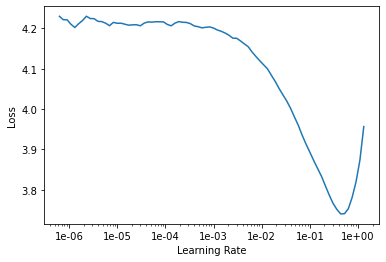

In [61]:
learn.recorder.plot(skip_end=10)


In [62]:
# as a rule of thumb, review the plot above and choose the learning rate with the steepest slope to fit the model
learn.fit_one_cycle(40, 1e-2, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,4.191718,3.806524,0.245536,00:00
1,4.147721,3.713983,0.255952,00:00
2,4.088407,3.616575,0.271726,00:00
3,4.016553,3.541648,0.280357,00:00
4,3.931158,3.471267,0.288690,00:00
5,3.837974,3.419085,0.290476,00:00
6,3.734998,3.360668,0.292857,00:00
7,3.629359,3.313789,0.291964,00:00
8,3.514880,3.296511,0.292560,00:00
9,3.402521,3.292879,0.292560,00:00


In [63]:
learn.save(stor_path/'models/deep_philosopher_head')


In [64]:
learn.load(stor_path/'models/deep_philosopher_head');

In [65]:
learn.unfreeze()

In [66]:
learn.fit_one_cycle(80, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.608582,3.775159,0.251786,00:00
1,1.601264,3.774205,0.255060,00:00
2,1.581975,3.810191,0.252976,00:00
3,1.558100,3.848574,0.251786,00:00
4,1.543243,3.884786,0.253274,00:00
5,1.521868,3.904082,0.251488,00:00
6,1.492076,3.948315,0.251190,00:00
7,1.461621,3.991401,0.246429,00:00
8,1.426844,4.010464,0.258631,00:00
9,1.393766,4.051111,0.247321,00:00


In [67]:
learn.save(stor_path/'models/deep_philosopher_fine_tuned')


In [19]:
learn.load(stor_path/'models/deep_philosopher_fine_tuned')


LanguageLearner(data=TextLMDataBunch;

Train: LabelList (149 items)
x: LMTextList
xxbos [ xxmaj xxunk ] enclose xxunk xxunk . xxmaj small · xxunk · enclose material that has been added , but can be xxunk as though it were part of the xxunk xxunk . xxmaj xxunk xxunk , and also xxunk of xxunk that are not xxunk , are meant as xxunk to xxunk the structure of a xxunk or a thought . xxmaj every xxunk - point xxunk . . . . xxunk the xxunk of a xxunk xxunk that seems to present more difficulty than it is xxunk .,xxbos xxmaj in his xxunk for this work , xxmaj descartes is following a xxunk ( started by xxmaj xxunk ) which uses ‘ first xxunk ’ as a xxunk for xxunk .,xxbos xxmaj some xxunk ago i was xxunk by how many false things i had believed , and by how doubtful was the structure of beliefs that i had based on them . i realized that if i wanted to xxunk anything in the xxunk that was xxunk and likely to last , i needed — just once in my life — to xxunk everything completely and start again f

In [32]:
# adjust below parameters to test inference (generated texts)

TEXT = "Life will"
N_WORDS = 60
N_SENTENCES = 2


In [41]:
print("\n".join(learn.predict(TEXT, N_WORDS) for _ in range(N_SENTENCES)))


Life will is complete and complete by means of the natural light , and is complete ( as i am awake ) ? That is where the most important things —
Life will vividly and clearly is vividly and clearly imply the truth ; innate knowledge and also knowledge of knowledge will mislead on through the senses ; and somehow in imagination it


In [33]:
pred_raw = learn.predict(TEXT, N_WORDS, temperature=0.8, min_p=0.0001, no_unk=True)
print(pred_raw)

Life will has from experience all this perfections to him — for all his perfections as well as his perfections — not for all of them to have brought it about that there is no he - ( or none that i understand ) between the perfections that i attribute to God . When on the other hand i examine


In [38]:
pred_raw.split('.')[:-1]

['Life will has from experience all this perfections to him — for all his perfections as well as his perfections — not for all of them to have brought it about that there is no he - ( or none that i understand ) between the perfections that i attribute to God ']